## AB Tests

In [ ]:
pip install causalml

     |████████████████████████████████| 245kB 5.4MB/s 
     |████████████████████████████████| 20.1MB 1.4MB/s 
     |████████████████████████████████| 327kB 27.3MB/s 
     |████████████████████████████████| 1.8MB 8.8MB/s 
     |████████████████████████████████| 634kB 34.2MB/s 
  Created wheel for causalml: filename=causalml-0.10.0-cp37-cp37m-linux_x86_64.whl size=493712 sha256=e091f2e72085c9cd6f0f592d990f103803b9bd427f7f04392419dc1ebe91865f
  Stored in directory: /root/.cache/pip/wheels/81/7f/44/c9d5ecf03f0d950f53302a5eab1c76bec07bcd5868753e22bf
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465047 sha256=40bcfda1534c7d2ca6976aad923fecfc747af1d08e41712b727decdbde1c5e6d
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built causalml shap
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement 

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

from statsmodels.stats.power import ttest_power

import statsmodels.api as sm

from lightgbm import LGBMRegressor
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import BaseSRegressor
from causalml.inference.meta import BaseTRegressor
from causalml.inference.meta import BaseXRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# PATH = './student_data'

In [ ]:
"""
df_1 = pd.read_csv(f'{PATH}/dataset_part1_students.csv', sep='\t')
df_2 = pd.read_csv(f'{PATH}/dataset_part2_students.csv', sep='\t')
df_3 = pd.read_csv(f'{PATH}/dataset_part3_students.csv', sep='\t')
"""

"\ndf_1 = pd.read_csv(f'{PATH}/dataset_part1_students.csv', sep='\t')\ndf_2 = pd.read_csv(f'{PATH}/dataset_part2_students.csv', sep='\t')\ndf_3 = pd.read_csv(f'{PATH}/dataset_part3_students.csv', sep='\t')\n"

In [ ]:
df_1 = pd.read_csv('dataset_part1_students.csv', sep='\t')
df_2 = pd.read_csv('dataset_part2_students.csv', sep='\t')
df_3 = pd.read_csv('dataset_part3_students.csv', sep='\t')

### 1. Оценка результатов AB теста

В данном задании вам требуется оценить результаты AB теста. Даны результаты на контрольной и тестовой группе после проведения AB теста.
Помимо показателей целевой переменной, вам даны также несколько фичей, которые являются характеристиками объектов. Даны целевые показатели (y) и принадлежность к целевой группе (W).

</u>Задача:</u>
1. Проверьте подходящую для данных гипотезу о равенстве средних в выборках
2. Каков treatment effect нашего воздействия? (ATE) 
3. Примените известные вам методы оценки ATE с учетом особенностей данных.
4. Проанализируйте, сравните результаты применения различных методов.
5. В явном виде выпишите выводы.

</i>Примечание: предположения о рандомизированном эксперименте нуждаются в проверке - независимость treatment от объектов не гарантирована. Все предположения выписывайте явно.</i> 

Для данной задачи используется dataset:  dataset_part1_students.csv

In [ ]:
df_1.head()

,y,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,-1.459404,0.0,0.986277,0.873392,0.509746,0.271836,0.336919,0.216954,0.276477,0.343316,0.862159,0.156700
1,-1.694174,0.0,0.140887,0.757080,0.736325,0.355663,0.341093,0.666803,0.217101,0.561427,0.124179,0.319736
2,5.378374,0.0,0.953214,0.137357,0.569413,0.975665,0.503367,0.667664,0.034191,0.456119,0.155851,0.476049
3,2.188189,1.0,0.169702,0.896258,0.373394,0.379693,0.858317,0.646061,0.583462,0.668350,0.177793,0.849248
4,2.862696,1.0,0.442373,0.831468,0.763921,0.919691,0.070573,0.156165,0.636894,0.555696,0.191929,0.425656


In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       20000 non-null  float64
 1   W       20000 non-null  float64
 2   X_1     20000 non-null  float64
 3   X_2     20000 non-null  float64
 4   X_3     20000 non-null  float64
 5   X_4     20000 non-null  float64
 6   X_5     20000 non-null  float64
 7   X_6     20000 non-null  float64
 8   X_7     20000 non-null  float64
 9   X_8     20000 non-null  float64
 10  X_9     20000 non-null  float64
 11  X_10    20000 non-null  float64
dtypes: float64(12)
memory usage: 1.8 MB


In [ ]:
df_1.describe()

,y,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,2.075323,0.522300,0.501970,0.496674,0.501623,0.501036,0.497661,0.501234,0.497832,0.496958,0.499980,0.498894
std,3.035037,0.499515,0.288250,0.289476,0.289892,0.288132,0.288567,0.288967,0.287840,0.288291,0.288345,0.287987
min,-9.047982,0.000000,0.000159,0.000013,0.000057,0.000028,0.000004,0.000073,0.000110,0.000057,0.000012,0.000013
25%,0.026237,0.000000,0.251363,0.244871,0.251427,0.250494,0.250537,0.250726,0.249500,0.247673,0.251035,0.250138
50%,2.075935,1.000000,0.503203,0.496624,0.504957,0.498941,0.498581,0.499502,0.499507,0.492757,0.499955,0.500853
75%,4.140186,1.000000,0.751609,0.745780,0.753342,0.752575,0.746653,0.752015,0.744436,0.746960,0.748775,0.745164
max,13.895502,1.000000,0.999966,0.999936,0.999960,0.999987,0.999948,0.999885,0.999970,0.999913,0.999906,0.999982


#### Проверка независимости treatment от других объектов

Для этого построим классификатор. Если хороший классификатор не удается построить, значит, выборки хорошо разделены. 

In [ ]:
y = df_1['W']
X = df_1.drop(['y', 'W'], axis=1)

In [ ]:
clf = SGDClassifier()
print(f'Accuracy: {np.mean(cross_val_score(clf, X, y, scoring="accuracy"))}')
print(f'ROC-AUC: {np.mean(cross_val_score(clf, X, y, scoring="roc_auc"))}')
print(f'F1-measure: {np.mean(cross_val_score(clf, X, y, scoring="f1"))}')

Accuracy: 0.7312
ROC-AUC: 0.8012470655588514
F1-measure: 0.7668911685304824


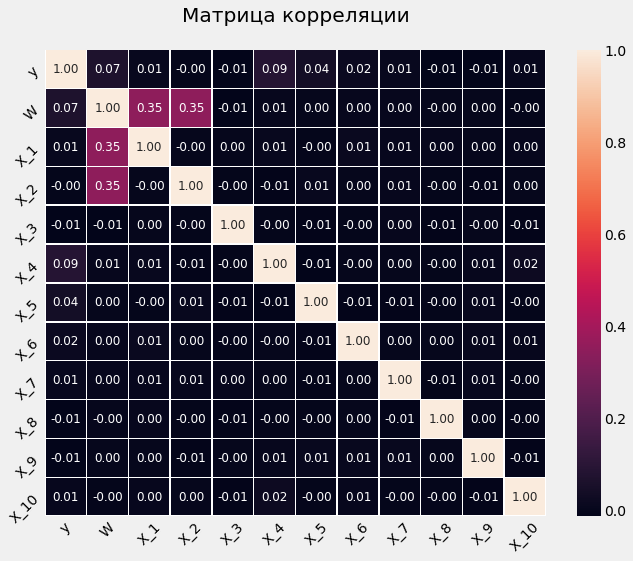

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_1.corr(), 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f",
            annot_kws={'fontsize': 12})
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Матрица корреляции\n');

Коррелированных признаков нет (есть только слабо и умеренно коррелированные).

In [ ]:
df_1.W.value_counts()

1.0    10446
0.0     9554
Name: W, dtype: int64

Классы не сбалансированы.

**Вывод:** хороший классификатор удалось построить, а значит, эксперимент нельзя считать рандомизированным.

Введем следующие предположения: условия **unconfoudedness** *(treatment не зависит от результата эксперимента при условии контроля за X)* и **overlap** *(нет таких характеристик объектов, для которых невозможен treatment)* выполнены.

#### Проверка распределения данных на нормальность

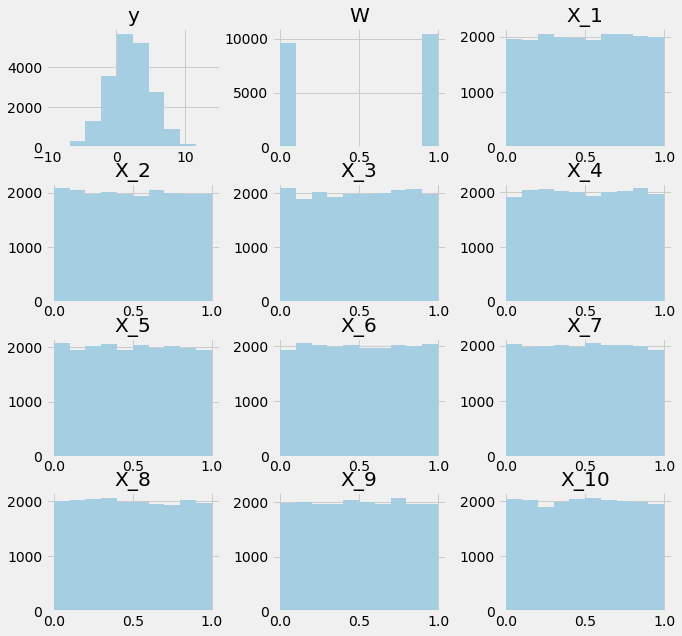

In [ ]:
df_1.hist(figsize=(10, 10));

In [ ]:
control = df_1[df_1.W == 0].y
treatment = df_1[df_1.W == 1].y

In [ ]:
control.describe()

count    9554.000000
mean        1.866349
std         3.027736
min        -9.047982
25%        -0.190188
50%         1.878149
75%         3.933886
max        13.895502
Name: y, dtype: float64

In [ ]:
treatment.describe()

count    10446.000000
mean         2.266452
std          3.029246
min         -8.822540
25%          0.217490
50%          2.254728
75%          4.340158
max         13.013761
Name: y, dtype: float64

**Нулевая гипотеза $H_0$:**

Распределение **y** в **control, treatment** нормальное.

**Альтернативная гипотеза $H_1$:**

Распределение **y** в **control, treatment** не является нормальным.

Для проверки гипотезы воспользуемся **критерием Шапиро-Уилка.**

Пороговое значение: $\alpha = 0.05$.

In [ ]:
alpha = 0.05

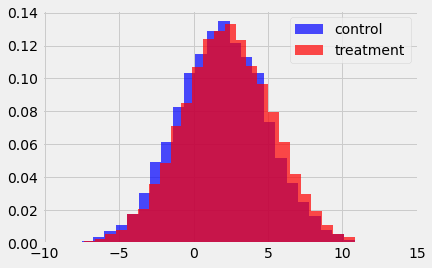

In [ ]:
plt.hist(control, bins=30, density=True, color='blue', alpha=0.7, label='control')
plt.hist(treatment, bins=30, density=True, color='red', alpha=0.7, label='treatment')
plt.legend()
plt.show()

In [ ]:
stat, pvalue = sps.shapiro(control)
print(f'stat: {stat}, pvalue: {pvalue}')

stat: 0.9998553991317749, pvalue: 0.837329626083374


p-value may not be accurate for N > 5000.


In [ ]:
if (pvalue < alpha):
    print('Отвергаем гипотезу H_0')
else:
    print('Принимаем гипотезу H_0')

Принимаем гипотезу H_0


In [ ]:
stat, pvalue = sps.shapiro(treatment)
print(f'stat: {stat}, pvalue: {pvalue}')

stat: 0.9998707175254822, pvalue: 0.8599085807800293


p-value may not be accurate for N > 5000.


In [ ]:
if (pvalue < alpha):
    print('Отвергаем гипотезу H_0')
else:
    print('Принимаем гипотезу H_0')

Принимаем гипотезу H_0


**Вывод:** **y** в **control, treatment** распределены нормально.

#### Проверка гипотезы о равенстве средних в выборках

In [ ]:
print(f'Среднее значение y в control: {round(control.mean(), 2)}')
print(f'Среднее значение y в treatment: {round(treatment.mean(), 2)}')

Среднее значение y в control: 1.87
Среднее значение y в treatment: 2.27


**Нулевая гипотеза $H_0$:**

Средние значения **y** в **control** и **treatment** равны между собой.

**Альтернативная гипотеза $H_1$:**

Средние значения **y** в **control** и **treatment** не равны между собой.

Для проверки гипотезы воспользуемся **t-критерием Стьюдента**, так как здесь идет речь о сравнении средних в независимых выборках (нормально распределенных) при неизвестных дисперсиях.

Пороговое значение: $\alpha = 0.05$.

In [ ]:
alpha = 0.05

In [ ]:
print(f'Дисперсия y в control: {round(control.var(), 2)}')
print(f'Дисперсия y в treatment: {round(treatment.var(), 2)}')

Дисперсия y в control: 9.17
Дисперсия y в treatment: 9.18


Дисперсии двух выборок примерно равны, но все равно стоит провести 2 теста: один - **Welch's t-test** (дисперсии неизвестны, различные), другой - **two-sample t-test** (дисперсии неизвестны, равны).

**Two sample t-test**

In [ ]:
stat, pvalue = sps.ttest_ind(control, treatment, equal_var=True)
print(f'stat: {stat}, pvalue: {pvalue}')

stat: -9.332400850259313, pvalue: 1.1400916649505329e-20


In [ ]:
if (pvalue < alpha):
    print('Отвергаем гипотезу H_0')
else:
    print('Принимаем гипотезу H_0')

Отвергаем гипотезу H_0


**Welch's t-test**

In [ ]:
stat, pvalue = sps.ttest_ind(control, treatment, equal_var=False)
print(f'stat: {stat}, pvalue: {pvalue}')

stat: -9.332608430209014, pvalue: 1.1387356403808485e-20


In [ ]:
if (pvalue < alpha):
    print('Отвергаем гипотезу H_0')
else:
    print('Принимаем гипотезу H_0')

Отвергаем гипотезу H_0


#### Оценка значимости критерия путем расчета мощности критерия

In [ ]:
power = 0.8

In [ ]:
def cohend(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = np.mean(d1), np.mean(d2)
    return (u1 - u2) / s

In [ ]:
test_power = ttest_power(cohend(treatment, control), nobs=len(control), alpha=alpha)

In [ ]:
test_power

1.0

In [ ]:
if (test_power < power):
    print('Критерий не состоятельный')
else:
    print('Критерий состоятельный')

Критерий состоятельный


**Вывод:** гипотезу о равенстве средних нельзя принять $\Rightarrow$ средние значения целевой метрики **y** в группах **control** и **treatment** различные.

#### Оценка treatment effect нашего воздействия (ATE)

Если бы эксперимент был рандомизированным, то тогда $\tau_{ATE}$ был бы следующим:

In [ ]:
ate_naive = treatment.mean() - control.mean() 
print(f'ATE_naive: {ate_naive}')

ATE_naive: 0.4001031055444413


В случае нерандомизированного эксперимента, учитывая предположение об **unconfoundedness** и **overlap**, получим $\tau_{ATE}$ таким:

In [ ]:
y = df_1['y']
X = df_1.drop(['y'], axis=1)
X = sm.add_constant(X)

In [ ]:
model = sm.OLS(y, X)
res = model.fit()

In [ ]:
print(f'ATE_regr: {res.params.W}')

ATE_regr: 0.5133854882565607


Сравним полученные результаты: оценка $\tau_{ATE}$, произведенная регрессионным методом, получилась более точной, так как наивный способ не подходит в силу того, что эксперимент нельзя считать рандомизированным.

**Выводы:**
* данные хорошо разделены;
* распределение данных можно считать нормальным;
* введены предположения **unconfoudedness** и **overlap** ввиду того, что эксперимент не является рандомизированным;
* после проверки гипотезы о равенстве средних в **control** и **treatment** выборках было выявлено, что средние значения целевой метрики **y** в группах **control** и **treatment** различные:
    * среднее значение **y** в **control**: 1.87
    * среднее значение **y** в **treatment**: 2.27
* при оценке $\tau_{ATE}$ были получены такие результаты при различных методах:
    * $\tau_{naive}$: 0.40
    * $\tau_{regr}$: 0.51
* оценка $\tau_{ATE}$, произведенная регрессионным методом, получилась более точной, так как наивный способ не подходит в силу того, что эксперимент нельзя считать рандомизированным;
* выяснено, что после такого воздействия среднее значение целевой метрики **y** увеличится на 0.51

### 2. Оценка результатов AB теста с показателями до начала эксперимента

Необходимо как и ранее оценить результаты AB теста, а именно ATE. Вы располагаете результатами до и после проведения теста (y_0 и y_1), а также вам дан treatment assignment (W). 

Необходимо: 
1. Проверить все требуемые гипотезы
2. Оценить ATE подходящим для этого случая методом (примените несколько методов)
3. Сравнить и проанализировать результаты оценок
4. Явно выписать выводы.

Как и прежде, все предположения должны быть указаны. Визуализация результатов приветствуется.

dataset_part2_students.csv

In [ ]:
df_2.head()

,y_1,y_0,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,5.887156,2.785060,1.0,0.605978,0.733369,0.138947,0.312673,0.997243,0.128162,0.178993,0.752925,0.662161,0.784310
1,2.232601,5.533515,0.0,0.096894,0.058571,0.962396,0.616557,0.086630,0.561272,0.616525,0.963843,0.574304,0.371161
2,0.144419,0.095546,1.0,0.452145,0.201850,0.569305,0.195096,0.583704,0.476313,0.517814,0.823099,0.732225,0.069056
3,-2.446425,3.590472,1.0,0.672129,0.643485,0.828014,0.204469,0.617489,0.617701,0.301069,0.871741,0.589654,0.981770
4,2.163090,1.365405,0.0,0.442232,0.126318,0.508831,0.431786,0.915940,0.709016,0.890655,0.588886,0.636830,0.342209


In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y_1     10000 non-null  float64
 1   y_0     10000 non-null  float64
 2   W       10000 non-null  float64
 3   X_1     10000 non-null  float64
 4   X_2     10000 non-null  float64
 5   X_3     10000 non-null  float64
 6   X_4     10000 non-null  float64
 7   X_5     10000 non-null  float64
 8   X_6     10000 non-null  float64
 9   X_7     10000 non-null  float64
 10  X_8     10000 non-null  float64
 11  X_9     10000 non-null  float64
 12  X_10    10000 non-null  float64
dtypes: float64(13)
memory usage: 1015.8 KB


In [ ]:
df_2.describe()

,y_1,y_0,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.104517,0.751393,0.524000,0.494608,0.503882,0.498649,0.500041,0.499651,0.496875,0.502681,0.500391,0.502482,0.498343
std,2.075276,2.292416,0.499449,0.287804,0.287356,0.290250,0.289479,0.289714,0.288792,0.289304,0.289625,0.286766,0.287541
min,-5.772625,-7.895281,0.000000,0.000103,0.000027,0.000052,0.000086,0.000049,0.000002,0.000092,0.000053,0.000286,0.000036
25%,0.720403,-0.778216,0.000000,0.245372,0.255875,0.248544,0.248120,0.245991,0.243503,0.252856,0.249906,0.256388,0.251672
50%,2.088402,0.745162,1.000000,0.490941,0.504934,0.492483,0.498955,0.496116,0.497895,0.501308,0.497964,0.504018,0.492807
75%,3.482478,2.343497,1.000000,0.743003,0.750596,0.751100,0.753792,0.753868,0.743828,0.752798,0.753477,0.749514,0.749355
max,10.488659,9.988961,1.000000,0.999685,0.999707,0.999982,0.999913,0.999935,0.999989,0.999964,0.999944,0.999981,0.999915


#### Проверка независимости treatment от других объектов

Для этого построим классификатор. Если хороший классификатор не удается построить, значит, выборки хорошо разделены. 

In [ ]:
y = df_2['W']
X = df_2.drop(['y_1', 'y_0', 'W'], axis=1)

In [ ]:
clf = SGDClassifier()
print(f'Accuracy: {np.mean(cross_val_score(clf, X, y, scoring="accuracy"))}')
print(f'ROC-AUC: {np.mean(cross_val_score(clf, X, y, scoring="roc_auc"))}')
print(f'F1-measure: {np.mean(cross_val_score(clf, X, y, scoring="f1"))}')

Accuracy: 0.7405000000000002
ROC-AUC: 0.7982451568413624
F1-measure: 0.762491966297085


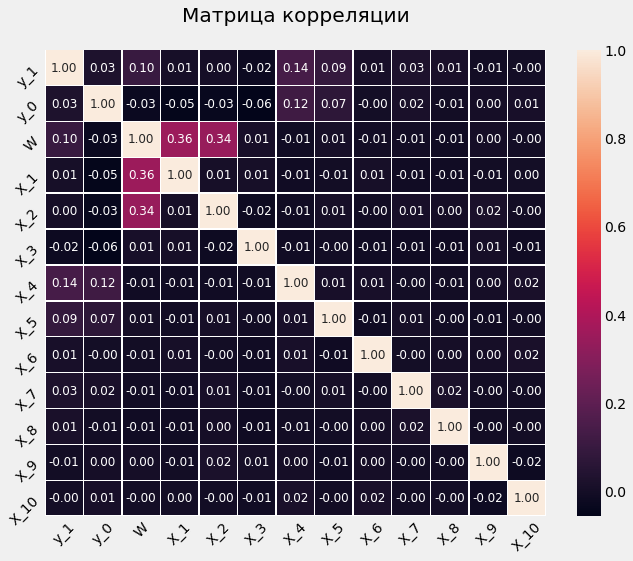

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_2.corr(), 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f",
            annot_kws={'fontsize': 12})
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Матрица корреляции\n');

Коррелированных признаков нет (есть только слабо и умеренно коррелированные).

In [ ]:
df_2.W.value_counts()

1.0    5240
0.0    4760
Name: W, dtype: int64

Классы не сбалансированы.

**Вывод:** хороший классификатор удалось построить, а значит, эксперимент нельзя считать рандомизированным.

Введем следующие предположения: условия **unconfoudedness** *(treatment не зависит от результата эксперимента при условии контроля за X)* и **overlap** *(нет таких характеристик объектов, для которых невозможен treatment)* выполнены.

#### Проверка распределения данных на нормальность

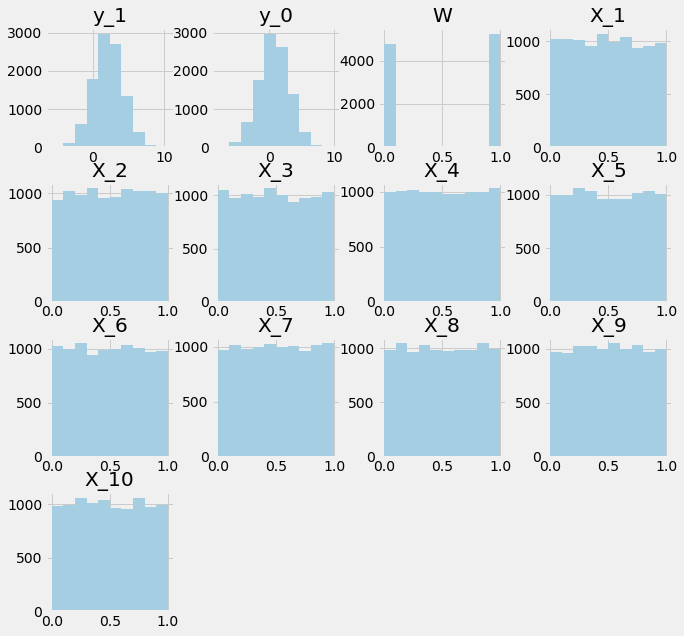

In [ ]:
df_2.hist(figsize=(10, 10));

In [ ]:
control_0 = df_2[df_2.W == 0].y_0
treatment_0 = df_2[df_2.W == 1].y_0
control_1 = df_2[df_2.W == 0].y_1
treatment_1 = df_2[df_2.W == 1].y_1

In [ ]:
control_0.describe()

count    4760.000000
mean        0.816187
std         2.229064
min        -6.972191
25%        -0.700460
50%         0.821256
75%         2.372783
max         9.988961
Name: y_0, dtype: float64

In [ ]:
treatment_0.describe()

count    5240.000000
mean        0.692534
std         2.347146
min        -7.895281
25%        -0.866791
50%         0.679592
75%         2.298276
max         9.748107
Name: y_0, dtype: float64

In [ ]:
control_1.describe()

count    4760.000000
mean        1.878542
std         2.071818
min        -4.979060
25%         0.492818
50%         1.912860
75%         3.307287
max        10.068061
Name: y_1, dtype: float64

In [ ]:
treatment_1.describe()

count    5240.000000
mean        2.309793
std         2.057201
min        -5.772625
25%         0.929238
50%         2.286631
75%         3.657720
max        10.488659
Name: y_1, dtype: float64

**Нулевая гипотеза $H_0$:**

Распределение **y_0, y_1** в **control, treatment** нормальное.

**Альтернативная гипотеза $H_1$:**

Распределение **y_0, y_1** в **control, treatment** не является нормальным.

Для проверки гипотезы воспользуемся **критерием Шапиро-Уилка.**

Пороговое значение: $\alpha = 0.05$.

In [ ]:
alpha = 0.05

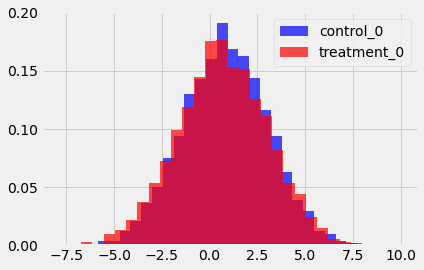

In [ ]:
plt.hist(control_0, bins=30, density=True, color='blue', alpha=0.7, label='control_0')
plt.hist(treatment_0, bins=30, density=True, color='red', alpha=0.7, label='treatment_0')
plt.legend()
plt.show()

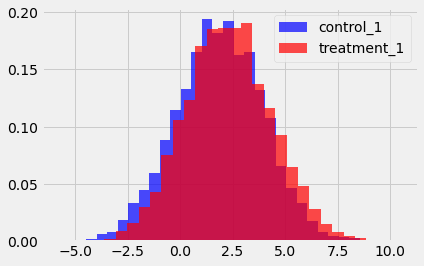

In [ ]:
plt.hist(control_1, bins=30, density=True, color='blue', alpha=0.7, label='control_1')
plt.hist(treatment_1, bins=30, density=True, color='red', alpha=0.7, label='treatment_1')
plt.legend()
plt.show()

In [ ]:
stat, pvalue = sps.shapiro(control_0)
print(f'stat: {stat}, pvalue: {pvalue}')

stat: 0.9996148347854614, pvalue: 0.5011960864067078


In [ ]:
if (pvalue < alpha):
    print('Отвергаем гипотезу H_0')
else:
    print('Принимаем гипотезу H_0')

Принимаем гипотезу H_0


In [ ]:
stat, pvalue = sps.shapiro(treatment_0)
print(f'stat: {stat}, pvalue: {pvalue}')

stat: 0.999710202217102, pvalue: 0.7005389332771301


p-value may not be accurate for N > 5000.


In [ ]:
if (pvalue < alpha):
    print('Отвергаем гипотезу H_0')
else:
    print('Принимаем гипотезу H_0')

Принимаем гипотезу H_0


In [ ]:
stat, pvalue = sps.shapiro(control_1)
print(f'stat: {stat}, pvalue: {pvalue}')

stat: 0.9994422197341919, pvalue: 0.16677731275558472


In [ ]:
if (pvalue < alpha):
    print('Отвергаем гипотезу H_0')
else:
    print('Принимаем гипотезу H_0')

Принимаем гипотезу H_0


In [ ]:
stat, pvalue = sps.shapiro(treatment_1)
print(f'stat: {stat}, pvalue: {pvalue}')

stat: 0.9994078874588013, pvalue: 0.088233083486557


p-value may not be accurate for N > 5000.


In [ ]:
if (pvalue < alpha):
    print('Отвергаем гипотезу H_0')
else:
    print('Принимаем гипотезу H_0')

Принимаем гипотезу H_0


**Вывод:** **y_0, y_1** в **control, treatment** распределены нормально.

#### Проверка гипотезы о равенстве средних в выборках

In [ ]:
print(f'Среднее значение y_0 в control: {round(control_0.mean(), 2)}')
print(f'Среднее значение y_0 в treatment: {round(treatment_0.mean(), 2)}')
print(f'Среднее значение y_1 в control: {round(control_1.mean(), 2)}')
print(f'Среднее значение y_1 в treatment: {round(treatment_1.mean(), 2)}')

Среднее значение y_0 в control: 0.82
Среднее значение y_0 в treatment: 0.69
Среднее значение y_1 в control: 1.88
Среднее значение y_1 в treatment: 2.31


**Нулевая гипотеза $H_0$:**

1. Средние значения **y_0** в **control** и **treatment** равны между собой.

2. Средние значения **y_1** в **control** и **treatment** равны между собой.

**Альтернативная гипотеза $H_1$:**

1. Средние значения **y_0** в **control** и **treatment** не равны между собой.

2. Средние значения **y_1** в **control** и **treatment** не равны между собой.

Для проверки гипотезы воспользуемся **t-критерием Стьюдента**, так как здесь идет речь о сравнении средних в независимых выборках (нормально распределенных) при неизвестных дисперсиях.

Пороговое значение: $\alpha = 0.05$.

In [ ]:
alpha = 0.05

In [ ]:
print(f'Дисперсия y_0 в control: {round(control_0.var(), 2)}')
print(f'Дисперсия y_0 в treatment: {round(treatment_0.var(), 2)}')
print(f'Дисперсия y_1 в control: {round(control_1.var(), 2)}')
print(f'Дисперсия y_1 в treatment: {round(treatment_1.var(), 2)}')

Дисперсия y_0 в control: 4.97
Дисперсия y_0 в treatment: 5.51
Дисперсия y_1 в control: 4.29
Дисперсия y_1 в treatment: 4.23


Дисперсии выборок примерно равны, но все равно стоит провести 2 теста: один - **Welch's t-test** (дисперсии неизвестны, различные), другой - **two-sample t-test** (дисперсии неизвестны, равны).

**Two sample t-test**

In [ ]:
stat, pvalue = sps.ttest_ind(control_0, treatment_0, equal_var=True)
print(f'stat: {stat}, pvalue: {pvalue}')

stat: 2.6947405425339337, pvalue: 0.007056118548053932


In [ ]:
if (pvalue < alpha):
    print('Отвергаем гипотезу H_0')
else:
    print('Принимаем гипотезу H_0')

Отвергаем гипотезу H_0


In [ ]:
stat, pvalue = sps.ttest_ind(control_1, treatment_1, equal_var=True)
print(f'stat: {stat}, pvalue: {pvalue}')

stat: -10.434076818229196, pvalue: 2.3383131389683154e-25


In [ ]:
if (pvalue < alpha):
    print('Отвергаем гипотезу H_0')
else:
    print('Принимаем гипотезу H_0')

Отвергаем гипотезу H_0


**Welch's t-test**

In [ ]:
stat, pvalue = sps.ttest_ind(control_0, treatment_0, equal_var=False)
print(f'stat: {stat}, pvalue: {pvalue}')

stat: 2.7014202424371874, pvalue: 0.0069160683710655525


In [ ]:
if (pvalue < alpha):
    print('Отвергаем гипотезу H_0')
else:
    print('Принимаем гипотезу H_0')

Отвергаем гипотезу H_0


In [ ]:
stat, pvalue = sps.ttest_ind(control_1, treatment_1, equal_var=False)
print(f'stat: {stat}, pvalue: {pvalue}')

stat: -10.430531043827909, pvalue: 2.433950215267867e-25


In [ ]:
if (pvalue < alpha):
    print('Отвергаем гипотезу H_0')
else:
    print('Принимаем гипотезу H_0')

Отвергаем гипотезу H_0


#### Оценка значимости критерия путем расчета мощности критерия

In [ ]:
power = 0.8

In [ ]:
test_power_0 = ttest_power(cohend(treatment_0, control_0), nobs=len(control_0), alpha=alpha)

In [ ]:
test_power_0

0.9609591747486333

In [ ]:
if (test_power_0 < power):
    print('Критерий не состоятельный')
else:
    print('Критерий состоятельный')

Критерий состоятельный


In [ ]:
test_power_1 = ttest_power(cohend(treatment_1, control_1), nobs=len(control_1), alpha=alpha)

In [ ]:
test_power_1

1.0

In [ ]:
if (test_power_1 < power):
    print('Критерий не состоятельный')
else:
    print('Критерий состоятельный')

Критерий состоятельный


**Вывод:** гипотезу о равенстве средних нельзя принять $\Rightarrow$ средние значения целевой метрики **y_0** в группах **control** и **treatment** различные и средние значения целевой метрики **y_1** в группах **control** и **treatment** различные.

**Нулевая гипотеза $H_0$:**

1. Средние значения **y_0**, **y_1** в **control** равны между собой.

2. Средние значения **y_0**, **y_1** в **treatment** равны между собой.

**Альтернативная гипотеза $H_1$:**

1. Средние значения **y_0**, **y_1** в **control** не равны между собой.

2. Средние значения **y_0**, **y_1** в **treatment** не равны между собой.

Для проверки гипотезы воспользуемся **t-критерием Стьюдента** для связанных выборок, так как здесь идет речь о сравнении средних в зависимых выборках (нормально распределенных) при неизвестной дисперсии.

Пороговое значение: $\alpha = 0.05$.

In [ ]:
alpha = 0.05

In [ ]:
print(f'Дисперсия y_0 в control: {round(control_0.var(), 2)}')
print(f'Дисперсия y_0 в treatment: {round(treatment_0.var(), 2)}')
print(f'Дисперсия y_1 в control: {round(control_1.var(), 2)}')
print(f'Дисперсия y_1 в treatment: {round(treatment_1.var(), 2)}')

Дисперсия y_0 в control: 4.97
Дисперсия y_0 в treatment: 5.51
Дисперсия y_1 в control: 4.29
Дисперсия y_1 в treatment: 4.23


**Two sample rel t-test**

In [ ]:
stat, pvalue = sps.ttest_rel(control_0, control_1)
print(f'stat: {stat}, pvalue: {pvalue}')

stat: -24.166958754890345, pvalue: 8.294420851409134e-122


In [ ]:
if (pvalue < alpha):
    print('Отвергаем гипотезу H_0')
else:
    print('Принимаем гипотезу H_0')

Отвергаем гипотезу H_0


In [ ]:
stat, pvalue = sps.ttest_rel(treatment_0, treatment_1)
print(f'stat: {stat}, pvalue: {pvalue}')

stat: -38.44253146154512, pvalue: 4.8441785663390546e-285


In [ ]:
if (pvalue < alpha):
    print('Отвергаем гипотезу H_0')
else:
    print('Принимаем гипотезу H_0')

Отвергаем гипотезу H_0


**Вывод:** гипотезу о равенстве средних нельзя принять $\Rightarrow$ средние значения целевых метрик **y_0, y_1** в группе **control** различные и средние значения целевых метрик **y_0, y_1** в группе **treatment** различные.

#### Оценка treatment effect нашего воздействия (ATE)

**ANCOVA:**

In [ ]:
y = df_2['y_1']
X = df_2[['y_0', 'W']]
X = sm.add_constant(X)

In [ ]:
model = sm.OLS(y, X)
res = model.fit()

In [ ]:
print(f'ATE_ancova: {res.params.W}')

ATE_ancova: 0.43448638144566576


**Difference in differences (DiD)**:

In [ ]:
did_0 = df_2.loc[:, ['y_0', 'W']].rename(columns={'y_0':'y'})
did_0['T'] = 0
did_1 = df_2.loc[:, ['y_1', 'W']].rename(columns={'y_1':'y'})
did_1['T'] = 1

In [ ]:
did = pd.concat((did_0, did_1))

In [ ]:
did['WT'] = did['W'] * did['T']

In [ ]:
y = did['y']
X = did.drop(['y'], axis=1)

In [ ]:
model = sm.OLS(y, X)
res = model.fit()

In [ ]:
print(f'ATE_did: {res.params.W}')

ATE_did: 0.692533849085882


Сравним полученные результаты: оценка $\tau_{ATE}$, произведенная методом **DiD**, получилась более хорошей, чем **ANOVA**, так как в последнем не учитывается неравномерное разбиение на группы.

**Выводы:**
* данные хорошо разделены;
* распределение данных можно считать нормальным;
* введены предположения **unconfoudedness** и **overlap** ввиду того, что эксперимент не является рандомизированным;
* после проверки гипотезы о равенстве средних в **control** и **treatment** выборках было выявлено, что:
    * средние значения целевой метрики **y_0** (перед экспериментом) в группах **control** и **treatment** различные 
    * средние значения целевой метрики **y_1** (после эксперимента) в группах **control** и **treatment** различные
    * средние значения целевых метрик **y_0, y_1** в группе **control** различные 
    * средние значения целевых метрик **y_0, y_1** в группе **treatment** различные.
* численные значения следующие:
    * среднее значение **y_0** в **control:** 0.82
    * среднее значение **y_0** в **treatment:** 0.69
    * среднее значение **y_1** в **control:** 1.88
    * среднее значение **y_1** в **treatment:** 2.31
* при оценке $\tau_{ATE}$ были получены такие результаты при различных методах:
    * $\tau_{ANCOVA}$: 0.43
    * $\tau_{DiD}$: 0.69
* оценка $\tau_{ATE}$, произведенная методом **DiD**, получилась более хорошей, чем **ANOVA**, так как в последнем не учитывается неравномерное разбиение на группы;
* выяснено, что после такого воздействия среднее значение целевой метрики **y** увеличится на 0.69

### 3. Построение uplift модели по результатам AB теста.

Вам даны результаты AB теста для модели конверсии клиента в продукте (conversion). Конверсия может принимать значения 1 или 0, что значит - клиент подключил услугу, либо не подключил соответственно.

Задача:
1. Оцените ATE по данным.
2. Оцените CATE для каждого наблюдения.
3. Проставьте рекомендации к воздействию на каждый объект.
4. Какая ожидаемая конверсия при оптимальном воздействии?
5. Все выводы, предпосылки и методы представляйте в явном виде в ноутбуке.

Визуализация результатов также будет приветствоваться.

dataset_part3_students.csv

In [ ]:
df_3.head()

,treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion
0,control,0.034351,0.550725,-1.348524,-0.029591,0.499535,-0.412464,0.933588,-0.522954,-0.029591,-0.807218,1.318646,-0.065262,-0.956947,-0.314573,-0.879456,0.640264,1.165722,0.570495,0.529443,0.227962,1.929914,0.798664,0
1,control,-1.059404,0.299404,0.220273,-1.569660,1.084204,-2.167118,1.216469,-0.744547,-1.569660,-0.460971,-1.396720,0.600044,1.000000,0.303664,1.080643,2.646483,-0.329690,1.725636,1.434649,-2.064893,0.188000,-1.134651,0
2,control,0.051934,2.338729,-0.341017,-1.099362,0.693090,-2.424267,1.572066,-0.212798,-1.099362,-1.430502,0.469694,1.251940,0.943003,-0.083721,-1.981712,0.224777,2.038004,2.516398,2.324280,-3.182196,-0.888490,-1.402561,0
3,treatment,0.667770,0.539316,0.468719,-0.840885,-0.708331,0.126634,1.275854,-0.954919,-0.840885,0.408691,-0.422736,-1.593407,0.247038,-0.752011,-0.347319,-1.659402,-0.871980,-0.893513,-0.658078,-2.704997,-0.390745,-1.578004,1
4,control,-1.416158,2.486628,0.496402,-1.174618,2.738267,-4.756755,-0.180918,-1.281432,-1.174618,-0.243256,0.598662,0.750706,0.554053,-1.198151,-0.232961,0.948875,1.210523,1.536723,1.548610,-0.926435,0.972459,-0.711251,0


In [ ]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 24 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   treatment   200000 non-null  object 
 1   X_1         200000 non-null  float64
 2   X_2         200000 non-null  float64
 3   X_3         200000 non-null  float64
 4   X_4         200000 non-null  float64
 5   X_5         200000 non-null  float64
 6   X_6         200000 non-null  float64
 7   X_7         200000 non-null  float64
 8   X_8         200000 non-null  float64
 9   X_9         200000 non-null  float64
 10  X_10        200000 non-null  float64
 11  X_11        200000 non-null  float64
 12  X_12        200000 non-null  float64
 13  X_13        200000 non-null  float64
 14  X_14        200000 non-null  float64
 15  X_15        200000 non-null  float64
 16  X_16        200000 non-null  float64
 17  X_17        200000 non-null  float64
 18  X_18        200000 non-null  float64
 19  X_

In [ ]:
df_3.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,-0.366881,1.000991,0.001935,-0.756540,1.000084,-1.667107,1.000705,-0.000710,-0.756540,0.005147,-0.001179,0.001210,0.000445,0.000694,-0.001166,0.730801,0.724893,0.729323,0.713093,-0.454716,0.454133,-0.226181,0.152935
std,0.747049,1.260868,1.004051,1.374899,1.244811,2.063263,1.040636,0.999507,1.374899,1.001864,1.001020,1.002052,1.000733,0.997000,0.999781,1.295677,1.156846,1.376184,1.125988,1.454906,1.343870,0.882719,0.359926
min,-4.260103,-4.369495,-4.670829,-5.754862,-5.983915,-10.220168,-4.166615,-4.227920,-5.754862,-4.777980,-4.546409,-4.445577,-4.550388,-4.528661,-4.401616,-5.578769,-5.638730,-4.638177,-3.808153,-6.811223,-4.291047,-4.069459,0.000000
25%,-0.862987,0.149688,-0.672525,-1.661703,0.167853,-3.060503,0.315748,-0.675240,-1.661703,-0.672295,-0.675308,-0.676829,-0.672417,-0.669325,-0.678250,-0.098053,0.104129,-0.228769,-0.067630,-1.525196,-0.547735,-0.837005,0.000000
50%,-0.373147,0.999645,0.005157,-0.864479,1.001572,-1.686846,0.999920,-0.001920,-0.864479,0.007714,0.000699,0.001778,0.001085,-0.002532,-0.000079,0.800327,0.839588,0.764489,0.740424,-0.372879,0.506115,-0.193615,0.000000
75%,0.120436,1.851332,0.680293,-0.012428,1.832482,-0.296865,1.682196,0.671658,-0.012428,0.678861,0.675092,0.677818,0.676277,0.671813,0.670672,1.620866,1.500485,1.686777,1.495407,0.747596,1.431963,0.411282,0.000000
max,4.121888,6.726024,4.976332,9.593777,6.820825,9.094394,7.081333,5.439752,9.593777,4.325225,4.957473,4.247420,4.873599,4.482854,5.125249,5.660769,4.982925,6.418469,5.431105,5.147421,6.085848,3.196679,1.000000


#### Проверка независимости treatment от других объектов

Для этого построим классификатор. Если хороший классификатор не удается построить, значит, выборки хорошо разделены. 

In [ ]:
y = df_3['treatment']
X = df_3.drop(['treatment', 'conversion'], axis=1)

In [ ]:
clf = SGDClassifier()
print(f'Accuracy: {np.mean(cross_val_score(clf, X, y, scoring="accuracy"))}')
print(f'ROC-AUC: {np.mean(cross_val_score(clf, X, y, scoring="roc_auc"))}')

Accuracy: 0.49879999999999997
ROC-AUC: 0.49948269000000006


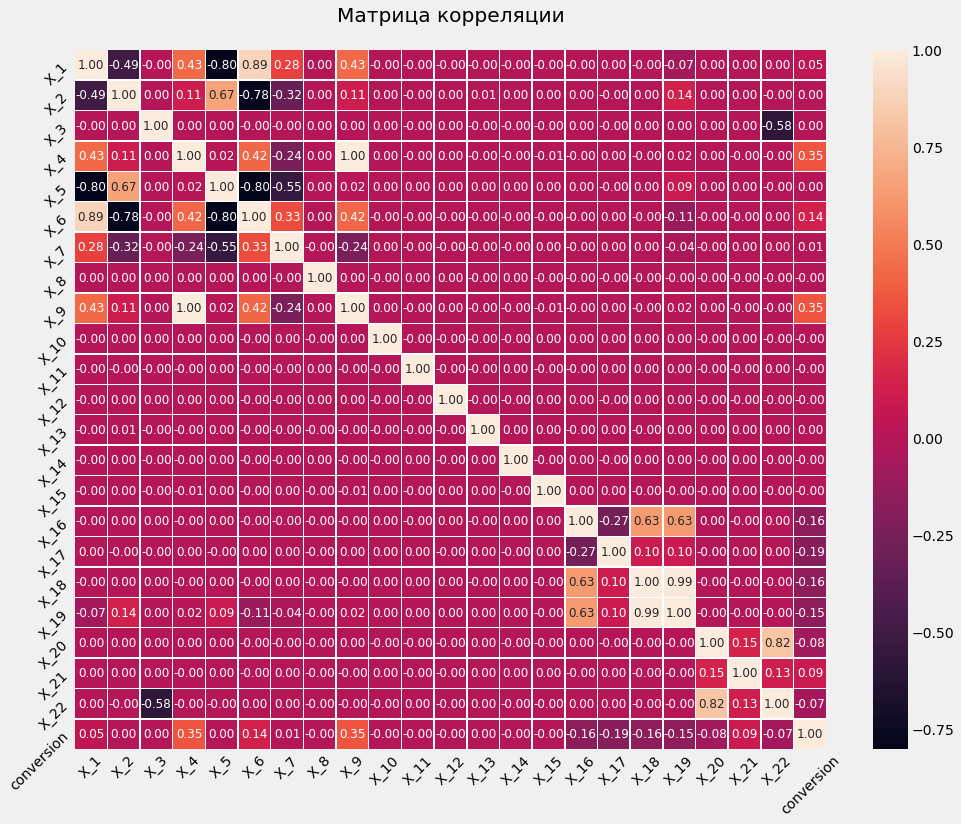

In [ ]:
plt.figure(figsize=(15, 12))
sns.heatmap(df_3.corr(), 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f",
            annot_kws={'fontsize': 12})
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Матрица корреляции\n');

Коррелированные (высокая степень) признаки присутствуют.

In [ ]:
df_3.treatment.value_counts()

control      100000
treatment    100000
Name: treatment, dtype: int64

Классы сбалансированы.

**Вывод:** хороший классификатор не удалось построить, а значит, эксперимент можно считать рандомизированным.

#### Оценка ATE по данным

In [ ]:
control = df_3[df_3.treatment == 'control'].conversion
treatment = df_3[df_3.treatment == 'treatment'].conversion

Так как эксперимент можно считать рандомизированным, то можно рассчитать $\tau_{ATE}$ так:

In [ ]:
ate_naive = treatment.mean() - control.mean() 
print(f'ATE_naive: {ate_naive}')

ATE_naive: 0.05907


Также можно рассчитать и методом регрессии:

In [ ]:
y = df_3.conversion
X = df_3.drop(['treatment', 'conversion'], axis=1)
treatment = df_3.treatment

In [ ]:
lrsr = LRSRegressor(control_name='control')

In [ ]:
ate, lb, ub = lrsr.estimate_ate(X, treatment, y)

In [ ]:
print(f'ATE_regr: {ate[0]},\nconfidence interval: [{round(lb[0], 3)}, {round(ub[0], 3)}]')

ATE_regr: 0.06024252397448881,
confidence interval: [0.058, 0.063]


#### Оценка CATE для каждого наблюдения

#### S-Learner

In [ ]:
slearner = BaseSRegressor(learner=LGBMRegressor(), control_name='control')
slearner_tau = slearner.fit_predict(X=X, treatment=treatment, y=y)

In [ ]:
slearner_tau

array([[ 0.00823286],
       [-0.01387564],
       [ 0.00572399],
       ...,
       [-0.03531382],
       [-0.02345746],
       [-0.01263931]])

#### T-Learner

In [ ]:
tlearner = BaseTRegressor(learner=LGBMRegressor(), control_name='control')
tlearner_tau = tlearner.fit_predict(X=X, treatment=treatment, y=y)

In [ ]:
tlearner_tau

array([[ 0.03342534],
       [ 0.01486357],
       [ 0.00589053],
       ...,
       [-0.02443826],
       [-0.02763914],
       [-0.02968764]])

#### X-Learner

In [ ]:
xlearner = BaseXRegressor(learner=LGBMRegressor(), control_name='control')
xlearner_tau = xlearner.fit_predict(X=X, treatment=treatment, y=y)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


In [ ]:
xlearner_tau

array([[ 0.02042093],
       [ 0.01452562],
       [ 0.01555976],
       ...,
       [-0.01488617],
       [-0.01508615],
       [-0.01577335]])

#### Рекомендации к воздействию на каждый объект

Выделим группы **persuadables** при **S-, L-, X-Learner**, на объекты которых и будем совершать воздействие. Пусть их **CATE** $\ge 0.2$.

In [ ]:
cate_s, cate_t, cate_x = pd.Series(slearner_tau[:, 0]),\
                         pd.Series(tlearner_tau[:, 0]),\
                         pd.Series(xlearner_tau[:, 0])

In [ ]:
recs_s = cate_s.copy()
recs_s[recs_s >= 0.2] = 1
recs_s[recs_s != 1] = 0

In [ ]:
recs_t = cate_t.copy()
recs_t[recs_t >= 0.2] = 1
recs_t[recs_t != 1] = 0

In [ ]:
recs_x = cate_x.copy()
recs_x[recs_x >= 0.2] = 1
recs_x[recs_x != 1] = 0

In [ ]:
uplift = pd.DataFrame({'cate_s': cate_s,
                       'recs_s': recs_s,
                       'cate_t': cate_t,
                       'recs_t': recs_t,
                       'cate_x': cate_x,
                       'recs_x': recs_x})

In [ ]:
uplift.recs_s.value_counts()

0.0    180681
1.0     19319
Name: recs_s, dtype: int64

In [ ]:
uplift.recs_t.value_counts()

0.0    180107
1.0     19893
Name: recs_t, dtype: int64

In [ ]:
uplift.recs_x.value_counts()

0.0    180617
1.0     19383
Name: recs_x, dtype: int64

In [ ]:
print(f'Число persuadables при S-Learner: {uplift[uplift.recs_s == 1].recs_s.count()}')
print(f'Число persuadables при T-Learner: {uplift[uplift.recs_t == 1].recs_t.count()}')
print(f'Число persuadables при X-Learner: {uplift[uplift.recs_x == 1].recs_x.count()}')

Число persuadables при S-Learner: 19319
Число persuadables при T-Learner: 19893
Число persuadables при X-Learner: 19383


#### Ожидаемая конверсия при оптимальном воздействии

In [ ]:
conversion = df_3[df_3['conversion'] == 1].shape[0] / df_3.shape[0] 

In [ ]:
print(f'Конверсия до воздействия: {conversion}')

Конверсия до воздействия: 0.152935


In [ ]:
exp_conversion_s = uplift[(uplift['recs_s'] == 1) & (df_3['conversion'] == 1)].shape[0] /\
    uplift[uplift['recs_s'] == 1].shape[0]
exp_conversion_t = uplift[(uplift['recs_t'] == 1) & (df_3['conversion'] == 1)].shape[0] /\
    uplift[uplift['recs_t'] == 1].shape[0]
exp_conversion_x = uplift[(uplift['recs_x'] == 1) & (df_3['conversion'] == 1)].shape[0] /\
    uplift[uplift['recs_x'] == 1].shape[0] 

In [ ]:
print(f'Конверсия при S-Learner: {exp_conversion_s}')
print(f'Конверсия при T-Learner: {exp_conversion_t}')
print(f'Конверсия при X-Learner: {exp_conversion_x}')

Конверсия при S-Learner: 0.5232154873440654
Конверсия при T-Learner: 0.5055044488010858
Конверсия при X-Learner: 0.5266470618583294


Сравним ожидаемую конверсию при оптимальном воздействии и конверсию до начала воздействия:
* $conversion_{before}$: 0.15
* $conversion_{after}S$: 0.52
* $conversion_{after}T$: 0.51
* $conversion_{after}X$: 0.53

Таким образом, конверсия выше при **uplift-моделировании**.

**Выводы:**
* классы сбалансированы;
* эксперимент является рандомизированным;
* при оценке $\tau_{ATE}$ были получены такие результаты при различных методах:
    * $\tau_{naive}$: 0.059
    * $\tau_{regr}$: 0.060
* для каждого наблюдения с помощью **S-, T-, X-Learner** было найдено значение **CATE**;
* по **CATE** были определены группы **persuadables** (их **CATE** $\ge 0.2$), на которых нужно оказывать воздействие;
* ожидаемая конверсия выше в случае **X-Learner**:
    * $conversion_{after}S$: 0.52
    * $conversion_{after}T$: 0.51
    * $conversion_{after}X$: 0.53
* конверсия выше при **uplift-моделировании** в случае **X-Learner**, чем конверсия до начала воздействия на 0.38.